In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

# Load the TensorBoard notebook extension
# Restart the jupyter notebook if you just installed TF 2.0 Beta
%load_ext tensorboard

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym
import datetime
from tqdm import tqdm

In [3]:
!rm -rf ./logs/

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [4]:
go_env = gym.make('gym_go:go-v0', size='S', reward_method='heuristic')

In [5]:
board_size = 7

# Machine Learning Models
Actor-Critic method

In [6]:
from tensorflow.keras import layers

In [7]:
class Actor(tf.keras.Model):
    def __init__(self):
        super(Actor, self).__init__()
        self.main = tf.keras.Sequential([
            layers.Conv2D(input_shape=(board_size, board_size, 4), bias_initializer="ones", 
                          filters=16, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=16, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=1, kernel_size=5, padding="same"),
            layers.Flatten(),
            layers.Softmax(),
            layers.Reshape((board_size, board_size))
        ])
        
        self.pass_decision = tf.keras.Sequential([
            layers.Conv2D(input_shape=(board_size, board_size, 4), bias_initializer="zeros", 
                          filters=16, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Flatten(),
            layers.Dense(4 * board_size**2),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(board_size**2),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(board_size),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(1),
            layers.Softmax(),
        ])
    def call(self, inputs):
        action_prob_distr = self.main(inputs)
        pass_decision = self.pass_decision(inputs)
        return action_prob_distr, pass_decision

In [8]:
actor = Actor()

In [9]:
critic = tf.keras.Sequential([
    layers.Conv2D(input_shape=(board_size, board_size, 4), bias_initializer="ones", 
                  filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=1, kernel_size=5, padding="same"),
    layers.Reshape((board_size, board_size))
])

In [10]:
import os
if not os.path.exists('tmp'):
    os.mkdir('tmp/')
actor.save_weights('tmp/opp.h5')
opponent = Actor()
opponent.load_weights('tmp/opp.h5')

In [11]:
state = go_env.reset()
state, reward, done, info = go_env.step((3,5))
state, reward, done, info = go_env.step((5,3))

In [12]:
def plot_state(state, channels_last=False):
    plt.figure()
    for i, (layer, name) in enumerate(zip([state[0], state[1], state[2], state[3]] if not channels_last else 
                                          [state[:,:,0], state[:,:,1], state[:,:,2], state[:,:,3]], 
                                          ['black', 'white', 'invalid', 'pass'])):
        plt.subplot(1,4,i+1)
        plt.title(name)
        plt.imshow(layer)
    plt.tight_layout()

Tensorflow expects images to be `channels last`. 

This can be adapted to with `tranpose`.


Ensure the `transpose` function doesn't change anything visually

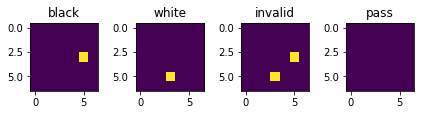

In [13]:
plot_state(state, channels_last=False)

In [14]:
state = state.transpose(1,2,0).reshape(1,7,7,4)

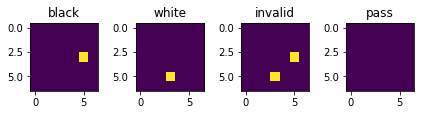

In [15]:
plot_state(state[0], channels_last=True)

### Initialization of models should be random

In [16]:
probs, pass_decision = actor(state.astype(np.float32))

In [17]:
values = critic.predict(state)

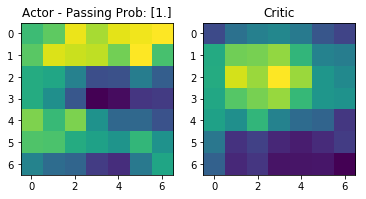

In [18]:
plt.subplot(1,2,1)
plt.title('Actor - Passing Prob: {}'.format(pass_decision[0]))
plt.imshow(probs[0])
plt.subplot(1,2,2)
plt.title('Critic')
plt.imshow(values[0])

# Training Setup

### Hyperparameters

In [19]:
NUM_EPISODES = 10
BATCH_SIZE = 64
REPLAY_MEM_SIZE = 1e6
OPPONENT_UPDATE = 10

In [20]:
from collections import deque

In [21]:
memory = deque(maxlen=int(REPLAY_MEM_SIZE))

### Metrics and Tensorboard

Metrics

In [22]:
actor_loss = tf.keras.metrics.Mean('actor_loss', dtype=tf.float32)
critic_loss = tf.keras.metrics.Mean('critic_loss', dtype=tf.float32)

Tensorboard

In [23]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

Demo usage for tensorboard

In [24]:
%tensorboard --logdir logs/gradient_tape

Reusing TensorBoard on port 6006 (pid 49533), started 18:05:28 ago. (Use '!kill 49533' to kill it.)

In [25]:
import random
for episode in tqdm(range(NUM_EPISODES)):
    # Pretend we just played
    
    # Simulate actor losses per batch
    for _ in range(1000):
        batch_actor_loss = random.uniform(0,10)
        
        # Add it to the metric
        actor_loss(batch_actor_loss)
                
    # Simulate critic losses per batch
    for _ in range(1000):
        batch_critic_loss = random.uniform(0,10)
        
        # Add it to the metric
        critic_loss(batch_critic_loss)
    
    with train_summary_writer.as_default():
        # Update tensorboard with metric
        tf.summary.scalar('critic loss', critic_loss.result(), step=episode)
        # Update tensorboard with metric
        tf.summary.scalar('actor loss', actor_loss.result(), step=episode)

    # Reset the metrics
    actor_loss.reset_states()
    critic_loss.reset_states()

100%|██████████| 10/10 [00:11<00:00,  1.02s/it]


### Functions

In [26]:
def get_action(actor, state):
    illegal_mask = state[2]
    state = state.transpose(1,2,0).reshape(1,7,7,4)
    act_prob_distr, pass_decision = actor(state.astype(np.float32))
    
    # decide whether to pass
    pass_choice = np.random.uniform()
    will_pass = pass_choice < pass_decision[0][0]
    if will_pass:
        return None
    
    # mask out the illegal move
    masked_prob = np.where(illegal_mask == 0, act_prob_distr, 0)
    sum_prob = np.sum(masked_prob)
    
    # if there is no more legal move, have to pass
    if sum_prob == 0:
        return None
    
    # make a move based on probability distribution
    masked_prob = masked_prob / sum_prob
    action_1d = np.random.choice(np.arange(49), p=masked_prob.flatten())
    action = (action_1d // 7, action_1d % 7)
    
    return action

In [33]:
def play(episode):
    '''
    :return: number of turns in this game, winner ('b'/'w'/None)
    '''
    done = False
    num_of_turns = 0
    state = go_env.reset()
    
    while not done:
        # actor makes a move
        action = get_action(actor, state)
        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        
        if done:
            break
        
        # opponent makes a move
        # swap the black and white layers
        temp = state[0]
        state[0] = state[1]
        state[1] = temp
        # get action from opponent
        action = get_action(opponent, state)
        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
          
    if reward > 0:
        winner = 'b'
        winner_log = 1
    elif reward == 0:
        winner = None
        winner_log = 0
    else:
        winner = 'w'
        winner_log = -1
        
    # log results
    with train_summary_writer.as_default():
        tf.summary.scalar('number of moves', num_of_turns, step=episode)
        tf.summary.scalar('winner', winner_log, step=episode)
    
    return num_of_turns, winner

In [28]:
def update_critic():
    pass

In [29]:
def update_actor():
    pass

In [30]:
def train(episode):
    if episode % OPPONENT_UPDATE == 0:
        # TODO sync opponent
        pass
    
    play(episode)
    update_critic()
    
    update_actor()

# Train

In [34]:
for episode in range(NUM_EPISODES):
    train(episode)

# Evaluate
Play against the actor 💪

In [ ]:
go_env = gym.make('gym_go:go-v0', size='S')

state = go_env.reset()

while True:
    go_env.render()
    
    # Actor's move
    action = get_action(state)
    
    state, reward, done, info = go_env.step(action)
    
    go_env.render()
    
    # Player's move
    player_moved = False
    while not player_moved:
        coords = input("Enter coordinates separated by space\n")
        coords = coords.split()
        try:
            row = int(coords[0])
            col = int(coords[1])
            print(row, col)
            state, reward, done, info = go_env.step((row, col))
            player_moved = True
        except Exception as e:
            print(e)